# Subtracting glitches using an auxiliary witness

This tutorial explains how to use data from an auxiliary channel to model and subtract excess power in LIGO strain data due to glitches.

Code similar to that introduced in this tutorial was used to subtract noise in LIGO data from glitches nearby gravitational-wave signals. Note that additional considerations, such as variations in the coupling function with respect to time and more careful treatment of correlated noise, are included in analyses that are a part of LIGO-Virgo-KAGRA publications. You can find more details about noise subtraction used in recent observing runs in the following publications: 

* [O3 Glitch Subtraction Publication](https://arxiv.org/abs/2207.03429)
* [Subtraction Methods Publication](https://arxiv.org/abs/1809.05348)

## Download data

To model and subtract glitches in our strain data, we need the strain data and an auxiliary channel that witnesses the source of the glitch. If the glitch isn't witnessed by any auxiliary channel, we aren't able to subtract the glitch with this method. 

In this case, we will grab data from around the gravitational-wave event GW200129_065458.

In [1]:
from gwpy.timeseries import TimeSeries

gps = 1264316116 #time of GW200129_065458
gps_exact = 1264316116.4

data_window = 1024
data_start = gps - data_window
data_end = gps + data_window


In [2]:
strain_data = TimeSeries.fetch('L1:DCS-CALIB_STRAIN_CLEAN_SUB60HZ_C01_AR', 
                        start=data_start, end=data_end, host='losc-nds.ligo.org').resample(2048)

In [3]:
aux_data = TimeSeries.fetch('L1:LSC-POP_A_RF9_I_ERR_DQ', 
                        start=data_start, end=data_end, host='losc-nds.ligo.org')

## Measure the transfer function

The critical step in this process is measuring the transfer function between the strain data and the auxiliary channel. To measure this function with the required amount of precision, several data pre-processing steps are required. For this reason, this tutorial uses several python functions based on the `gwsubtract` package. This package was used in the LIGO-Virgo-KAGRA analyses of GW200129_065458. You can download the complete code via [gitlab](https://git.ligo.org/derek.davis/gwsubtract). We have reproduced the relevant code in this notebook. 

In [4]:
import numpy as np
from numpy.fft import rfft
import scipy.signal as sig
from pycbc import types

def inner_product(data1,data2):
    # function to estimate the inner product between two frequency series
    # ensures that the data is properly windowed
    # in practice, the two series are often the same data
    srate1=data1.sample_rate
    srate2=data2.sample_rate
    fdata1=rfft(sig.hann(len(data1))*data1.detrend(type='constant').numpy())
    fdata2=rfft(sig.hann(len(data2))*data2.detrend(type='constant').numpy())
    max_idx=min(len(fdata1),len(fdata2))
    return types.frequencyseries.FrequencySeries(fdata1[:max_idx]*fdata2.conjugate()[:max_idx],
                            delta_f=1./data1.duration,epoch=data1.start_time)

def avg_freq_bins(fdata,new_df,tol=2.5e-9):
    # average the measured transfer function in nearby frequency bins
    # to reduce the amount of random correlations in the resulting 
    # transfer function estimated
    # based on the method instroduced in https://arxiv.org/abs/gr-qc/9909083
    nyquist=(len(fdata)-1)*fdata.delta_f
    new_flen=1+int(nyquist/float(new_df))
    binlen=int(new_df/float(fdata.delta_f))
    win=sig.hann(2*binlen)
    win/=np.sum(win)
    result=np.zeros(new_flen,dtype=fdata.dtype)
    for idx in range(1,new_flen-1):
        result[idx]=np.sum(win*fdata.numpy()[binlen*(idx-1):binlen*(idx+1)])
    result[np.absolute(result) < max(np.absolute(result))*tol] = 0
    return types.frequencyseries.FrequencySeries(result,delta_f=new_df,
                            epoch=fdata.start_time)

def avg_inner_product(d1, d2, new_df=1.,tol=2.5e-9):
    # combine the two functions above 
    if new_df > d1.delta_f:
        out = avg_freq_bins(inner_product(d1, d2), new_df,tol=tol)
    else:
        out_np = (inner_product(d1, d2)).numpy()
        out_np[np.absolute(out_np) < max(np.absolute(out_np))*tol] = 0
        out = types.frequencyseries.FrequencySeries(out_np,delta_f=d1.delta_f,
                            epoch=d1.start_time)
    return out


def measure_tf(target, witness, df=1.):
    # function to use the above functions to first pre-process the data
    # and then divide the two resulting frequency series
    # to estimate the transfer function
    iprod1=avg_inner_product(target,witness, df,tol=0)
    iprod2=avg_inner_product(witness,witness, df,tol=0)
    max_idx=min(len(iprod1),len(iprod2))
    result = np.array(np.divide(iprod1[:max_idx],iprod2[:max_idx]))
    result[0] = 0.
    result[-1] = 0.
    return types.frequencyseries.FrequencySeries(result,
                            delta_f=df,epoch=target.start_time)


Now that we've set up the relevant functions, let's calculate our transfer function!

In [5]:
tf = measure_tf(strain_data.to_pycbc(), aux_data.to_pycbc(), df=1.)

/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39/lib/python3.9/site-packages/pycbc/types/array.py:217: RuntimeWarning: invalid value encountered in true_divide
  ret = getattr(ufunc, method)(*inputs, **kwargs)


/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39/lib/python3.9/site-packages/gwpy/plot/bode.py:53: RuntimeWarning: divide by zero encountered in log10
  return 10 * numpy.log10(a)


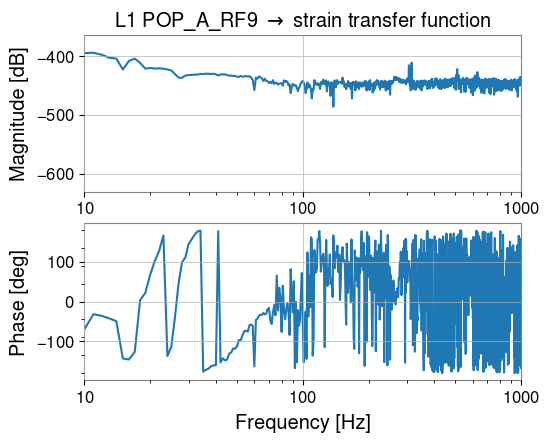

In [6]:
from gwpy.frequencyseries import FrequencySeries
from gwpy.plot import BodePlot

plot = BodePlot(FrequencySeries.from_pycbc(tf))
plot.maxes.set_title(
    r'L1 POP_A_RF9 $\rightarrow$ strain transfer function')
plot.maxes.set_xlim(10, 1000)
#plot.maxes.set_ylim(-55, 50)
plot.show()

The above plot shows the phase and amplitude of the measured transfer function. While the measured amplitude is relatively smooth with respect to frequency, the phase is almost random across most of the frequency spectrum! However, there are a few areas where the phase is smoothly varying. In particular, between 25 and 100 Hz. 

## Subtract glitches using transfer function

Now that we have measured the transfer function, we can subtract the glitches from our data! First, we will crop the data to focus on just the data around our event. 

In [7]:
crop_window = 32
strain_data_crop = strain_data.crop(gps-crop_window, gps+crop_window)
aux_data_crop = aux_data.crop(gps-crop_window, gps+crop_window)

To correctly apply the measured transfer function to the auxiliary channel data, we will use code adapted from the `pycbc.strain` package. 

In [8]:
import pycbc.psd
from pycbc.types import Array

# first convert the gwpy timeseries to pycbc timeseries
strain_data_pycbc = strain_data_crop.to_pycbc().astype(np.float64)
aux_data_pycbc = aux_data_crop.to_pycbc().astype(np.float64)
stilde_pycbc = strain_data_pycbc.to_frequencyseries()

# interpolate the transfer function 
# and convert it to a time-domain filter
tf_pycbc = pycbc.psd.interpolate(tf, stilde_pycbc.delta_f)
tf_time = tf_pycbc.to_timeseries()

# window the time-domain filter 
# so that it has a length of 2 seconds
filter_length = 2
flen = int(filter_length * strain_data_pycbc.sample_rate)
window = Array(np.hanning(flen * 2), dtype=strain_data_pycbc.dtype)
tf_time[0:flen] *= window[flen:]
tf_time[len(tf_time)-flen:] *= window[0:flen]

# convert back to the frequency domain
tf_pycbc = tf_time.to_frequencyseries()

# apply the transfer function to the auxilairy channel data
# and subtract the result from our strain data
kmax = min(len(tf_pycbc), len(stilde_pycbc) - 1)
stilde_pycbc[:kmax] -= tf_pycbc[:kmax] * aux_data_pycbc.to_frequencyseries()[:kmax]

# convert the timeseries back into gwpy
strain_data_sub = TimeSeries.from_pycbc(stilde_pycbc.to_timeseries())

## Visualize results

Now that we have glitch-subtracted data, let's visualize our result! Let's first compare the time series of our data before and after subtraction. We can even zoom in near the GW event time to get a better look. 

In order to better see the difference between the two time series, we first need to whiten and bandpass our data. 

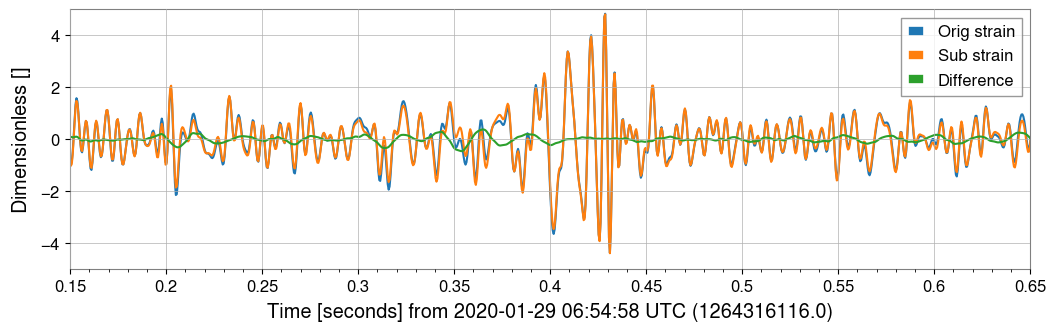

In [9]:
plot_window = 0.25

asd = strain_data.asd()

white_strain = strain_data_crop.whiten(asd=asd).bandpass(20,250)
white_strain_sub = strain_data_sub.whiten(asd=asd).bandpass(20,250)

plot = white_strain.plot(label='Orig strain')
ax = plot.gca()
ax.plot(white_strain_sub, label='Sub strain')
ax.plot(white_strain-white_strain_sub, label='Difference')


ax.set_xlim(gps_exact-plot_window, gps_exact+plot_window)
ax.set_ylim(-5, 5)
ax.legend()
plot.show()

Comparing the data before (blue) and after (orange) subtraction, we can see that the difference (green) is often quite small! However, the most significant differences are about 0.1 seconds before the merger time of the gravitational-wave signal! Excess noise that overlaps a gravitational-wave signal like this could pose a problem if we didn't do anything to address the glitch. 

Let's now compare spectrograms of the data before and after subtraction. 

In [10]:
qspecgram_orig = strain_data_crop.q_transform(qrange=(10,12), frange=(20, 500), 
                                              outseg=(gps_exact-1, gps_exact+4))

plot = qspecgram_orig.plot(figsize=[8, 4])
ax = plot.gca()
ax.set_xscale('seconds')
ax.set_yscale('log')
ax.set_ylim(20, 500)
ax.set_ylabel('Frequency [Hz]')
ax.grid(True, axis='y', which='both')
ax.colorbar(cmap='viridis', label='Normalized energy', clim=[0,25])
plot.show()

In [11]:
qspecgram_sub = strain_data_sub.q_transform(qrange=(10,12), frange=(20, 500), 
                                            outseg=(gps_exact-1, gps_exact+4))

plot = qspecgram_sub.plot(figsize=[8, 4])
ax = plot.gca()
ax.set_xscale('seconds')
ax.set_yscale('log')
ax.set_ylim(20, 500)
ax.set_ylabel('Frequency [Hz]')
ax.grid(True, axis='y', which='both')
ax.colorbar(cmap='viridis', label='Normalized energy', clim=[0,25])
plot.show()

The subtraction worked quite well! The glitches between 20 and 100 Hz in the time range of 2 to 6 seconds are no longer visible. While it's challenging to know if we have removed all noise contributions from the glitches, the data is much cleaner now!